In [1]:
import torch
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from dgl.nn import GraphConv,SAGEConv
import dgl
from dgl.data import DGLDataset
import seaborn as sns
import random
from tqdm import tqdm

In [ ]:
#データセットのグラフをクラス別のグラフごとに分割する
#train用とtest用に分割する
#各クラス別のグラフをそれぞれバッチグラフにする
#クラス順にembeddingネットワークに入力し埋め込み表現を取得しクラス別に保持
#各埋め込み表現のベクトルを同構造のグラフにノード特徴として代入
#各埋め込みグラフを一つのグラフに統合
#テスト用グラフをembeddingネットワークに入力
#得られた埋め込み表現ベクトルと統合グラフと類似度を計算し最も高いクラスを予測クラスとする


In [2]:
class ICPKGIDataset(DGLDataset):
    def __init__(self,data_path,transforms=None):
        self.data_path = data_path
        self.transforms = transforms
        super().__init__(name='ICPKGI_gprah')
    
    def process(self):
        GRAPHS, LABELS = dgl.load_graphs(self.data_path) #保存したグラーフデータの読み込み
        self.graphs = GRAPHS #グラフリストを代入
        self.labels = LABELS['label'] #ラベル辞書の値のみ代入
        self.dim_nfeats=len(self.graphs[0].ndata['f'][0])

    def __getitem__(self, idx):
        if self.transforms == None:
            return self.graphs[idx], self.labels[idx]
        else:
            data=self.transforms(self.graphs[idx])
            return data,self.labels[idx]
    def __len__(self):
        return len(self.graphs)
    

class EmbeddingNetwork(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats):
        super(EmbeddingNetwork, self).__init__()
        self.conv1 = SAGEConv(in_feats, hidden_feats, aggregator_type='mean')
        self.conv2 = SAGEConv(hidden_feats, hidden_feats, aggregator_type='mean')
        self.conv3 = SAGEConv(hidden_feats, out_feats, aggregator_type='mean')
        '''self.conv1 = GraphConv(in_feats, hidden_feats)
        self.conv2 = GraphConv(hidden_feats, hidden_feats)'''
        self.flatt=nn.Flatten()

    def forward(self, g, features):
        '''x=self.flatt(features)
        x = torch.relu(self.conv1(g, x))
        x = self.conv2(g, x)
        #x = self.conv3(g,x)'''
        
        x = self.flatt(features)
        x = torch.relu(self.conv1(g,x))
        x = torch.relu(self.conv2(g,x))
        x = self.conv3(g,x)

        g.ndata['h'] = x
        return g
    

def train_test_split(data,data_num):
    shuffle_data=random.sample(data,len(data))
    return shuffle_data[:-data_num], shuffle_data[-data_num:]


In [3]:
graphs=[[] for _ in range(5)]
dataset=ICPKGIDataset('../data/ICPKGI/8patch_gray.dgl')


In [4]:
for graph,label in dataset:
    graphs[label].append(graph)

In [5]:
for i in graphs:
    print(len(i))

45
377
97
212
26


In [5]:
#device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

attempts_number=100
cos=nn.CosineSimilarity(2)
data_log={f'{i}':[] for i in range(5)}
for att in tqdm(range(attempts_number)):
    car_embedding=[]
    test_graphs=[]
    test_data_num=10
    model=EmbeddingNetwork(in_feats=1024,hidden_feats=512,out_feats=128)
    #model.to(device)

    #埋め込み
    for i in range(5):
        train,test=train_test_split(graphs[i],test_data_num)
        #train,test=train.to(device),test.to(device)
        test_graphs.append(test)
        #graphs_batched=dgl.batch(train).to(device)
        graphs_batched=dgl.batch(train)
        with torch.no_grad():
            embedding_graph=model(graphs_batched,graphs_batched.ndata['f'])
        unbatch_embedd_graphs=dgl.unbatch(embedding_graph)
        stack_feat=torch.stack([g.ndata['h'] for g in unbatch_embedd_graphs],dim=0)
        embedding_feat=torch.mean(stack_feat,dim=0)
        car_embedding.append(embedding_feat)
    car_embedding=torch.stack([d for d in car_embedding],0)

    #テスト
    for j in range(5):
        #graphs_batched=dgl.batch(test_graphs[j]).to(device)
        graphs_batched=dgl.batch(test_graphs[j])
        with torch.no_grad():
            embedding_graph=model(graphs_batched,graphs_batched.ndata['f'])
        unbatch_embedd_graphs=dgl.unbatch(embedding_graph)
        test_embedds=torch.stack([g.ndata['h'] for g in unbatch_embedd_graphs],dim=0)
        
        pred=[]
        labels=torch.tensor([j for _ in range(test_data_num)])
        for te in test_embedds:
            #cos_simi=torch.mean(cos(te,car_embedding),1)
            cos_simi=torch.mean(torch.abs(cos(te,car_embedding)),1)
            pred.append(cos_simi.argmax().item())
        num_correct = (torch.tensor(pred) == labels).sum().item()
        data_log[f'{j}'].append(num_correct/test_data_num)
for k in range(5):
    log=data_log[f'{k}']
    print(f'class {k} ----- min:{min(log)}  max:{max(log)}  average:{sum(log)/len(log)}')

100%|██████████| 100/100 [01:10<00:00,  1.42it/s]

class 0 ----- min:0.1  max:0.8  average:0.4359999999999999
class 1 ----- min:0.0  max:0.8  average:0.266
class 2 ----- min:0.0  max:0.7  average:0.38799999999999985
class 3 ----- min:0.2  max:0.9  average:0.46999999999999986
class 4 ----- min:0.0  max:0.4  average:0.185


In [8]:
plot_data=np.zeros((5,11),dtype=np.int8)
print(plot_data[0])
for d in data_log:
    for e in data_log[d]:
        #print(int(e*10))
        val=int(e*10)
        plot_data[int(d)][val]+=1

[0 0 0 0 0 0 0 0 0 0 0]


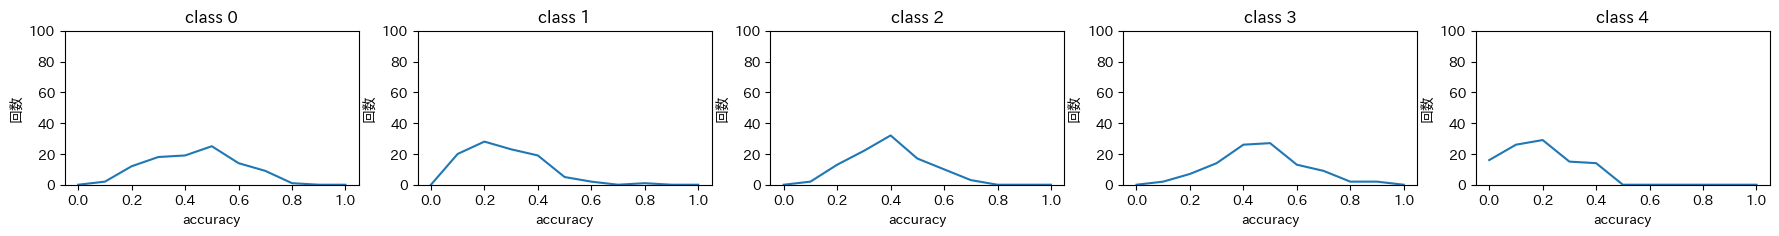

In [11]:
plt.figure(figsize=(22,2))
for p in range(5):
    plt.subplot(1,5,p+1)
    plt.title(f'class {p}')
    plt.ylim(0,100)
    plt.ylabel('回数')
    plt.xlabel('accuracy')
    plt.plot(np.arange(11)/10,plot_data[p])
plt.show()

In [ ]:
plt.figure(figsize=(20,2))
for p in range(5):
    plt.subplot(1,5,p+1)
    plt.title(f'class {p}')
    plt.ylim(0,100)
    plt.xlabel('accuracy')
    plt.plot(np.arange(11)/10,plot_data[p])
plt.show()

In [ ]:
'''# 共通の埋め込みを学習するモデルの定義
class CommonEmbeddingModel(nn.Module):
    def __init__(self, g,input_dim, embedding_dim):
        super(CommonEmbeddingModel, self).__init__()
        self.embedding_layer = GraphConv(input_dim,embedding_dim)

    def forward(self, x):
        return self.embedding_layer(g,x)
'''
class CommonEmbeddingModel(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super(CommonEmbeddingModel, self).__init__()
        self.embedding_layer = nn.Linear(input_dim, embedding_dim)

    def forward(self, x):
        return self.embedding_layer(x)
    
input_dim=10
# G1のダミーデータ（例）
G1_data = torch.randn((5, input_dim))

# G1の各ノードの埋め込みを取得
with torch.no_grad():
    embeddings_G1 = CommonEmbeddingModel(10,50)
    embeddings_G1 = embeddings_G1(G1_data)

# t-SNEを使用して埋め込みを2次元に削減
tsne = TSNE(n_components=2, random_state=42, perplexity=3)
embedded_G1 = tsne.fit_transform(embeddings_G1.numpy())

# k-meansクラスタリングを実行
num_clusters = 3  # クラスタ数
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings_G1)

# クラスタリング結果を可視化
plt.figure(figsize=(8, 8))
for i in range(len(embedded_G1)):
    color = 'blue' if cluster_labels[i] == 0 else 'red' if cluster_labels[i] == 1 else 'green'
    plt.scatter(embedded_G1[i, 0], embedded_G1[i, 1], c=color)

plt.title('k-means Clustering of G1 Embeddings')
plt.show()


In [ ]:
import numpy as np
from sklearn.manifold import TSNE
X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(X)


In [ ]:
print(X_embedded)

In [ ]:
# グラフの初期化
g = dgl.DGLGraph()
g.add_nodes(5)  # 5つのノードを追加

# エッジの追加（例：0から1、1から2、2から3、3から4、4から0へのエッジを追加）
src = [0, 1, 2, 3, 4,0,0]
dst = [1, 2, 3, 4, 0,2,4]
g.add_edges(src, dst)
g.ndata['f']=torch.randn((5,10))

In [ ]:
dgl.sampling.node2vec_random_walk(g,[0,1,2],1,1,4)

In [ ]:
import dgl
import torch
import dgl.nn as dglnn
from sklearn.cluster import KMeans

# Coraデータセットの読み込み
data = dgl.data.CoraGraphDataset()
g = data[0]


In [ ]:
print(g.ndata['feat'].shape)

In [ ]:
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats):
        super(GraphSAGE, self).__init__()
        self.sage1 = dglnn.SAGEConv(in_feats=in_feats, out_feats=hidden_feats, aggregator_type='mean')
        self.sage2 = dglnn.SAGEConv(in_feats=hidden_feats, out_feats=out_feats, aggregator_type='mean')

    def forward(self, g, features):
        x = self.sage1(g, features)
        x = torch.relu(x)
        x = self.sage2(g, x)
        x = torch.relu(x)
        return x
    

model = GraphSAGE(in_feats=1433, hidden_feats=128, out_feats=128)
# ノードの特徴量の取得
node_features = g.ndata['feat']

# グラフに特徴量を適用して埋め込みを学習
with torch.no_grad():
    emb = model(g, node_features)

# 学習された埋め込みを使用してクラスタリング
num_clusters = 10  # クラスタ数を指定
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(emb.cpu().numpy())

# 各ノードの所属クラスタを取得
cluster_labels = kmeans.labels_

# 結果の表示
for node, label in enumerate(cluster_labels):
    print(f"Node {node} belongs to cluster {label}")


In [ ]:
import dgl
import torch
import dgl.nn as dglnn
from dgl.dataloading import GraphDataLoader
import torch.nn as nn

'''# ダミーデータとしてラベル0のグラフ5つを作成
graphs = [dgl.graph(([0, 1, 1, 2], [1, 2, 3, 3])) for _ in range(5)]
# ランダムな特徴量をノードに割り当てる
for graph in graphs:
    graph = dgl.add_self_loop(graph)
    graph.ndata['feat'] = torch.randn(graph.num_nodes(), 1)
print(graphs)'''
graphs=[]
for _ in range(720):
    graph = dgl.graph(([0, 1, 1, 2], [1, 2, 3, 3]))
    graph = dgl.add_self_loop(graph)
    graph.ndata['feat'] = torch.randn(graph.num_nodes(), 1)
    graphs.append(graph)
# GCNモデルの定義
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats):
        super(GCN, self).__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hidden_feats)
        self.conv2 = dglnn.GraphConv(hidden_feats, out_feats)

    def forward(self, g, features):
        x = torch.relu(self.conv1(g, features))
        x = self.conv2(g, x)
        g.ndata['h'] = x
        return dgl.mean_nodes(g,'h')

# モデルの初期化
model = GCN(in_feats=1, hidden_feats=16, out_feats=3)  # 仮の次元とクラス数

# グラフをバッチ化し、GCNにかけて埋め込みを取得
graphs_batched = dgl.batch(graphs)
#print(graphs_batched.ndata['feat'])
with torch.no_grad():
    embeddings = model(graphs_batched, graphs_batched.ndata['feat'])


'''# 生成した新しいグラフの構造を取得
new_graph = dgl.to_bidirected(graphs[0].clone())  # 新しいグラフの構造を学習したい場合、最初のグラフをクローンする

# 新しいグラフの埋め込みを取得
with torch.no_grad():
    new_embeddings = model(new_graph, new_graph.ndata['feat'])'''
# ラベル0の埋め込み表現
print("Label 0 Embedding:", embeddings.shape)


In [ ]:
cos=nn.CosineSimilarity(1)
p0=torch.randn(5,10)
p1=torch.randn(10,10)

print(cos(p0,p1))